In [4]:
len(tf.config.list_physical_devices('GPU'))>0

True

In [5]:
import warnings
warnings.simplefilter('ignore')

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek
from collections import Counter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import model_selection

from xgboost import XGBClassifier
import lightgbm
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

In [6]:
df = pd.read_csv('Exoplanet hunting in Deep Space/data.csv')
df

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,-91.91,-92.97,-78.76,-97.33,-68.00,-68.24,-75.48,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,1,989.75,891.01,908.53,851.83,755.11,615.78,595.77,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,1,273.39,278.00,261.73,236.99,280.73,264.90,252.92,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1,3.82,2.09,-3.29,-2.88,1.66,-0.75,3.85,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


In [7]:
df.columns[df.isna().any()].tolist()

[]

In [8]:
df.describe()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
count,5087.000000,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,...,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000
mean,1.007273,1.445054e+02,1.285778e+02,1.471348e+02,1.561512e+02,1.561477e+02,1.469646e+02,1.168380e+02,1.144983e+02,1.228639e+02,...,3.485578e+02,4.956476e+02,6.711211e+02,7.468790e+02,6.937372e+02,6.553031e+02,-494.784966,-544.594264,-440.239100,-300.536399
std,0.084982,2.150669e+04,2.179717e+04,2.191309e+04,2.223366e+04,2.308448e+04,2.410567e+04,2.414109e+04,2.290691e+04,2.102681e+04,...,2.864786e+04,3.551876e+04,4.349963e+04,4.981375e+04,5.087103e+04,5.339979e+04,17844.469520,17722.339334,16273.406292,14459.795577
min,1.000000,-2.278563e+05,-3.154408e+05,-2.840018e+05,-2.340069e+05,-4.231956e+05,-5.975521e+05,-6.724046e+05,-5.790136e+05,-3.973882e+05,...,-3.240480e+05,-3.045540e+05,-2.933140e+05,-2.838420e+05,-3.288214e+05,-5.028894e+05,-775322.000000,-732006.000000,-700992.000000,-643170.000000
25%,1.000000,-4.234000e+01,-3.952000e+01,-3.850500e+01,-3.505000e+01,-3.195500e+01,-3.338000e+01,-2.813000e+01,-2.784000e+01,-2.683500e+01,...,-1.760000e+01,-1.948500e+01,-1.757000e+01,-2.076000e+01,-2.226000e+01,-2.440500e+01,-26.760000,-24.065000,-21.135000,-19.820000
50%,1.000000,-7.100000e-01,-8.900000e-01,-7.400000e-01,-4.000000e-01,-6.100000e-01,-1.030000e+00,-8.700000e-01,-6.600000e-01,-5.600000e-01,...,2.600000e+00,2.680000e+00,3.050000e+00,3.590000e+00,3.230000e+00,3.500000e+00,-0.680000,0.360000,0.900000,1.430000
75%,1.000000,4.825500e+01,4.428500e+01,4.232500e+01,3.976500e+01,3.975000e+01,3.514000e+01,3.406000e+01,3.170000e+01,3.045500e+01,...,2.211000e+01,2.235000e+01,2.639500e+01,2.909000e+01,2.780000e+01,3.085500e+01,18.175000,18.770000,19.465000,20.280000
max,2.000000,1.439240e+06,1.453319e+06,1.468429e+06,1.495750e+06,1.510937e+06,1.508152e+06,1.465743e+06,1.416827e+06,1.342888e+06,...,1.779338e+06,2.379227e+06,2.992070e+06,3.434973e+06,3.481220e+06,3.616292e+06,288607.500000,215972.000000,207590.000000,211302.000000


In [9]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [10]:
X.shape, y.shape

((5087, 3197), (5087,))

In [11]:
y.value_counts()

LABEL
1    5050
2      37
Name: count, dtype: int64

In [12]:
sm = SMOTETomek(random_state=42)

X_sampled, y_sampled = sm.fit_resample(X,y)

In [13]:
print('Original : ' + str(Counter(y)))
print('After Sampling : ' + str(Counter(y_sampled)))

Original : Counter({1: 5050, 2: 37})
After Sampling : Counter({2: 5050, 1: 5050})


In [14]:
X_sampled

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.850000,83.810000,20.100000,-26.980000,-39.560000,-124.710000,-135.180000,-96.270000,-79.890000,-160.170000,...,-78.070000,-102.150000,-102.150000,25.130000,48.570000,92.540000,39.320000,61.420000,5.080000,-39.540000
1,-38.880000,-33.830000,-58.540000,-40.090000,-79.310000,-72.810000,-86.550000,-85.330000,-83.970000,-73.380000,...,-3.280000,-32.210000,-32.210000,-24.890000,-4.860000,0.760000,-11.700000,6.460000,16.000000,19.930000
2,532.640000,535.920000,513.730000,496.920000,456.450000,466.000000,464.500000,486.390000,436.560000,484.390000,...,-71.690000,13.310000,13.310000,-29.890000,-20.880000,5.060000,-11.800000,-28.910000,-70.020000,-96.670000
3,326.520000,347.390000,302.350000,298.130000,317.740000,312.700000,322.330000,311.310000,312.420000,323.330000,...,5.710000,-3.730000,-3.730000,30.050000,20.030000,-12.670000,-8.770000,-17.310000,-17.350000,13.980000
4,-1107.210000,-1112.590000,-1118.950000,-1095.100000,-1057.550000,-1034.480000,-998.340000,-1022.710000,-989.570000,-970.880000,...,-594.370000,-401.660000,-401.660000,-357.240000,-443.760000,-438.540000,-399.710000,-384.650000,-411.790000,-510.540000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10095,133.493770,118.787141,90.581288,91.542993,70.308875,55.929915,52.456602,33.705937,29.998067,20.592595,...,15.844680,17.327926,-4.903961,-28.815544,-32.225996,-6.442056,0.735459,16.553187,11.153134,11.100302
10096,9.211984,-11.721115,-7.449412,-2.450139,-0.114952,-9.163189,4.027082,3.497715,8.822985,-3.720639,...,-12.879585,-0.392573,-0.392573,11.309057,16.137245,28.030902,4.040184,-1.405840,-4.572554,2.377456
10097,159.179169,135.716655,100.992667,100.561755,68.091558,45.019671,41.618471,11.564992,17.027252,-9.022716,...,-3.090579,13.846714,-29.465021,-42.347017,-44.026726,-31.456608,-25.475514,2.852107,7.087874,-9.210172
10098,13669.851819,11791.198415,9426.219594,7639.275311,6363.190252,4596.437105,4180.409789,2046.193622,629.590299,-741.970906,...,-764.690633,-2015.366412,-2917.688177,-2720.465910,-1940.675267,-1024.417617,207.300237,1017.021851,2261.636209,3187.588008


In [15]:
X_sampled.columns[X_sampled.isna().any()].tolist()

[]

In [16]:
%%time
pca = PCA(0.99)
pca.fit(X_sampled)
X_sampled = pca.transform(X_sampled)

CPU times: total: 1min 52s
Wall time: 1min 19s


Text(0, 0.5, 'cumulative explained variance')

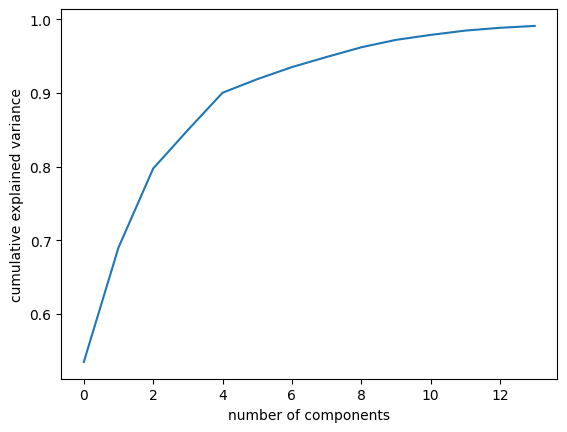

In [17]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [18]:
X_sampled

array([[ -6753.50329487,  -5967.06905939,  -4644.08891198, ...,
          -821.66716067,    101.24982318,   -340.80478425],
       [ -6958.84745361,  -6881.14831742,  -3937.10089086, ...,
          -554.22359253,   -875.56690057,   -416.66808398],
       [ -8343.19106291,  -4976.79299989,  -6946.12113681, ...,
          -569.13563552,   -440.29955212,   -580.76327469],
       ...,
       [ -6981.12613941,  -6434.91857965,  -4263.59141802, ...,
          -870.10862993,   -814.72003103,   -456.87576542],
       [-27230.79426803,  10435.95699234,   2752.73993379, ...,
          -811.09014823,  -3302.49619288,    219.67917311],
       [ -6589.58713728,  -6306.31490385,  -4336.16831083, ...,
          -658.52664008,   -819.38310247,   -440.13326271]])

In [19]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_sampled,y_sampled,test_size=0.3,random_state=42)

In [20]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((7070, 14), (3030, 14), (7070,), (3030,))

In [21]:
std = StandardScaler()

Xtrain = std.fit_transform(Xtrain,ytrain)
Xtest = std.transform(Xtest)

In [22]:
Xtrain

array([[-0.01397744, -0.01829654, -0.01724375, ..., -0.00610568,
         0.02412081, -0.01028485],
       [-0.01458663, -0.01596989, -0.02076171, ...,  0.00422846,
         0.00674033, -0.00585559],
       [-0.01369953, -0.01848371, -0.01672569, ..., -0.00499962,
        -0.02709446, -0.01164337],
       ...,
       [-0.01222469, -0.02989407, -0.02413945, ..., -0.00443599,
        -0.01782989, -0.01426865],
       [-0.00527068, -0.02220628, -0.01926709, ...,  0.02661498,
         0.10514758, -0.01907008],
       [-0.01469603, -0.01809577, -0.01875115, ..., -0.00393696,
        -0.01312588, -0.01243602]])

In [23]:
print('Mean = ',np.mean(Xtrain))
print('Std = ',np.std(Xtrain))

print('Mean = ',np.mean(Xtest))
print('Std = ',np.std(Xtest))

Mean =  -4.495629301573679e-18
Std =  1.0
Mean =  0.004253456292339609
Std =  1.7912048842383186


### Outliers (if any)

In [24]:
# IQR to remove outliers

def remove_outlier(data):
    percent_75 = np.percentile(data, 75)
    percent_25 = np.percentile(data, 25)
    
    iqr = percent_75 - percent_25
    
    upper_limit = percent_75 + 1.5 * iqr
    lower_limit = percent_25 - 1.5 * iqr
    
    # Capping outliers
    data = np.where(data > upper_limit, upper_limit, np.where(data < lower_limit, lower_limit, data))
    
    return data

In [25]:
Xtrain = remove_outlier(Xtrain)
Xtest = remove_outlier(Xtest)

In [26]:
vif = pd.DataFrame()

vif['name'] = [i for i in range(1,Xtrain.shape[1]+1)]
vif['vif score'] = [variance_inflation_factor(Xtrain,i) for i in range(Xtrain.shape[1])]

vif

,name,vif score
0,1,4.599400
1,2,7.167036
2,3,6.610457
3,4,7.191240
4,5,2.826224
5,6,6.412860
6,7,43.106670
7,8,29.423871
8,9,4.241203
9,10,6.620572


#### Very high collinearity b/w features 7,8

In [27]:
drop_columns_from_Xtrain = [6,7] #feature number start from 0
Xtrain_filtered = np.delete(Xtrain,drop_columns_from_Xtrain,axis=1)
Xtest_filtered = np.delete(Xtest,drop_columns_from_Xtrain,axis=1) #same for Xtest

In [28]:
Xtrain.shape, Xtrain_filtered.shape

((7070, 14), (7070, 12))

In [29]:
Xtest.shape, Xtest_filtered.shape

((3030, 14), (3030, 12))

In [30]:
Xtrain_filtered.shape, Xtest_filtered.shape, ytrain.shape, ytest.shape

((7070, 12), (3030, 12), (7070,), (3030,))

In [31]:
type(Xtrain_filtered), type(Xtest_filtered), type(ytrain), type(ytest)

(numpy.ndarray,
 numpy.ndarray,
 pandas.core.series.Series,
 pandas.core.series.Series)

### Model Building

In [143]:
def build_model(hyperparam):
    
    model = Sequential()
    counter=0 #to check if it is the first layer
    
    for i in range(hyperparam.Int('num_layers',min_value=2,max_value=20)):
        
        #if the constructing first layer
        if counter==0:
            model.add(Dense(
                hyperparam.Int('num_units'+str(i),min_value=8,max_value=128,step=8),
                hyperparam.Choice('activation'+str(i),values=['relu','tanh','selu','sigmoid']),
                kernel_regularizer='l2',kernel_initializer='he_uniform',
                input_dim = Xtrain_filtered.shape[1]))
            
        else:
            model.add(Dense(
                hyperparam.Int('num_units'+str(i),min_value=8,max_value=128,step=8),
                hyperparam.Choice('activation'+str(i),values=['relu','tanh','selu','sigmoid']),
                kernel_regularizer='l2',kernel_initializer='he_uniform'))
            model.add(BatchNormalization())
            model.add(Dropout(0.3))
            
        counter += 1
    
    model.add(Dense(1,activation='sigmoid')) #last layer
    model.compile(hyperparam.Choice('optimizer',values=['adam','adagrad','rmsprop','sgd']),
                  loss=['binary_crossentropy'],metrics='accuracy')
    
    return model   

In [145]:
tuner = kt.RandomSearch(hypermodel=build_model,
    objective=['val_accuracy'],max_trials=5,directory='Tuned params',project_name='trail5')

In [146]:
tuner.search(Xtrain_filtered,ytrain,validation_data=(Xtest_filtered,ytest),epochs=5)

Trial 5 Complete [00h 01m 21s]
multi_objective: -0.5161716341972351

Best multi_objective So Far: -0.5161716341972351
Total elapsed time: 00h 05m 50s
INFO:tensorflow:Oracle triggered exit


In [147]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 19,
 'num_units0': 56,
 'activation0': 'selu',
 'num_units1': 88,
 'activation1': 'relu',
 'optimizer': 'adam',
 'num_units2': 8,
 'activation2': 'relu',
 'num_units3': 8,
 'activation3': 'relu',
 'num_units4': 8,
 'activation4': 'relu',
 'num_units5': 8,
 'activation5': 'relu',
 'num_units6': 8,
 'activation6': 'relu',
 'num_units7': 8,
 'activation7': 'relu',
 'num_units8': 8,
 'activation8': 'relu',
 'num_units9': 8,
 'activation9': 'relu',
 'num_units10': 8,
 'activation10': 'relu',
 'num_units11': 8,
 'activation11': 'relu',
 'num_units12': 8,
 'activation12': 'relu',
 'num_units13': 8,
 'activation13': 'relu',
 'num_units14': 8,
 'activation14': 'relu',
 'num_units15': 8,
 'activation15': 'relu',
 'num_units16': 8,
 'activation16': 'relu',
 'num_units17': 8,
 'activation17': 'relu',
 'num_units18': 8,
 'activation18': 'relu'}

In [148]:
model = tuner.get_best_models()[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 56)                728       
                                                                 
 dense_1 (Dense)             (None, 88)                5016      
                                                                 
 batch_normalization (BatchN  (None, 88)               352       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 88)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 712       
                                                                 
 batch_normalization_1 (Batc  (None, 8)                32        
 hNormalization)                                        

In [151]:
early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.003,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,)

In [212]:
mc = ModelCheckpoint('dnn.h5', monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

In [230]:
%%time
history = model.fit(Xtrain_filtered,ytrain,batch_size=32,epochs=100,initial_epoch=5,validation_data=(Xtest_filtered,ytest),
         callbacks=[early_stopping,mc])

Epoch 6/100
221/221 [==============================] - ETA: 0s - loss: -79.7691 - accuracy: 0.4931
Epoch 6: val_accuracy did not improve from 0.51617
221/221 [==============================] - 20s 90ms/step - loss: -79.7691 - accuracy: 0.4931 - val_loss: -81.0847 - val_accuracy: 0.5162
Epoch 7/100
221/221 [==============================] - ETA: 0s - loss: -88.9406 - accuracy: 0.4931
Epoch 7: val_accuracy did not improve from 0.51617
221/221 [==============================] - 20s 93ms/step - loss: -88.9406 - accuracy: 0.4931 - val_loss: -90.7017 - val_accuracy: 0.5162
Epoch 8/100
221/221 [==============================] - ETA: 0s - loss: -99.5121 - accuracy: 0.4931
Epoch 8: val_accuracy did not improve from 0.51617
221/221 [==============================] - 20s 92ms/step - loss: -99.5121 - accuracy: 0.4931 - val_loss: -100.7197 - val_accuracy: 0.5162
Epoch 9/100
221/221 [==============================] - ETA: 0s - loss: -110.2386 - accuracy: 0.4931
Epoch 9: val_accuracy did not improve 

In [213]:
model.save_weights('dnn_weights.h5')

In [192]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

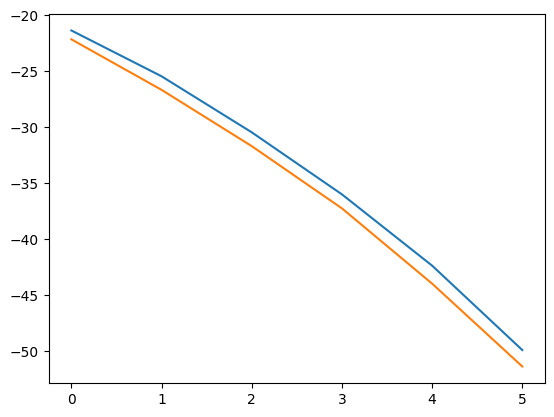

In [193]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## XGBoost

In [47]:
ytrain.replace({1:0,2:1}, inplace=True)

ytest.replace({1:0,2:1}, inplace=True)

In [48]:
xgb = XGBClassifier()

In [50]:
xgb_train = cross_val_score(xgb,Xtrain_filtered,ytrain,cv=StratifiedKFold(10),scoring='accuracy')
print('Training Accuracy = ',xgb_train.mean())

xgb_test = cross_val_score(xgb,Xtest_filtered,ytest,cv=StratifiedKFold(10),scoring='accuracy')
print('Testing Accuracy = ',xgb_test.mean())

Training Accuracy =  1.0
Testing Accuracy =  0.9712871287128714


In [52]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5],
}

tune = RandomizedSearchCV(xgb,params,cv=StratifiedKFold(10)) 
tune.fit(Xtrain_filtered,ytrain)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           impo...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]})

In [54]:
tune.best_params_

{'min_child_weight': 7, 'max_depth': 4, 'learning_rate': 0.25, 'gamma': 0.0}

In [56]:
xgb_tuned = XGBClassifier(min_child_weight=7, max_depth=4, learning_rate=0.25, gamma=0.0)

xgb_tuned_train = cross_val_score(xgb_tuned,Xtrain_filtered,ytrain,cv=StratifiedKFold(10),scoring='accuracy')
print('Training Accuracy = ',xgb_tuned_train.mean())

xgb_tuned_test = cross_val_score(xgb_tuned,Xtest_filtered,ytest,cv=StratifiedKFold(10),scoring='accuracy')
print('Testing Accuracy = ',xgb_tuned_test.mean())

Training Accuracy =  1.0
Testing Accuracy =  0.9613861386138612


### Lightgbm

In [177]:
lgbm = lightgbm.LGBMClassifier(verbosity=-1)

lgbm_train = cross_val_score(lgbm,Xtrain_filtered,ytrain,cv=StratifiedKFold(10),scoring='accuracy')
print('Training Accuracy = ',lgbm_train.mean())

lgbm_test = cross_val_score(lgbm,Xtest_filtered,ytest,cv=StratifiedKFold(10),scoring='accuracy')
print('Testing Accuracy = ',lgbm_test.mean())

Training Accuracy =  0.9830268741159831
Testing Accuracy =  0.9726072607260725


In [178]:
params = {
         'num_leaves':range(5,200),
         'max_depth':range(2,20),
         'max_bin':range(50,301,50),
         'min_data_in_bin':range(5,20),
          'learning_rate': [0.05,0.1,0.2,0.3,0.5,0.7],
          'n_estimators': [50,100,150,200,250,300,350]
         }

tune = RandomizedSearchCV(lgbm,params,cv=StratifiedKFold(10)) 
tune.fit(Xtrain_filtered,ytrain)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(verbosity=-1),
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.5, 0.7],
                                        'max_bin': range(50, 301, 50),
                                        'max_depth': range(2, 20),
                                        'min_data_in_bin': range(5, 20),
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 350],
                                        'num_leaves': range(5, 200)})

In [179]:
tune.best_estimator_

LGBMClassifier(max_bin=150, max_depth=13, min_data_in_bin=9, n_estimators=350,
               num_leaves=190, verbosity=-1)

In [181]:
lgbm_tuned = lightgbm.LGBMClassifier(max_bin=150, max_depth=13, min_data_in_bin=9, n_estimators=350,
               num_leaves=190, verbosity=-1)

lgbm_tuned_train = cross_val_score(lgbm_tuned,Xtrain_filtered,ytrain,cv=StratifiedKFold(10),scoring='accuracy')
print('Training Accuracy = ',lgbm_tuned_train.mean())

lgbm_tuned_test = cross_val_score(lgbm_tuned,Xtest_filtered,ytest,cv=StratifiedKFold(10),scoring='accuracy')
print('Testing Accuracy = ',lgbm_tuned_test.mean())

Training Accuracy =  0.9898161244695898
Testing Accuracy =  0.9762376237623764


## HistGBM

In [164]:
hist = HistGradientBoostingClassifier()

hist_train = cross_val_score(hist,Xtrain_filtered,ytrain,cv=StratifiedKFold(10),scoring='accuracy')
print('Training Accuracy = ',hist_train.mean())

hist_test = cross_val_score(hist,Xtest_filtered,ytest,cv=StratifiedKFold(10),scoring='accuracy')
print('Testing Accuracy = ',hist_test.mean())

Training Accuracy =  0.9826025459688827
Testing Accuracy =  0.971947194719472


In [165]:
params = {'learning_rate':[0.05, 0.1, 0.2, 0.3, 0.5],
         'max_leaf_nodes':range(2,35),
         'max_depth':range(2,30), 
         'min_samples_leaf':range(2,30),
         'l2_regularization': [0.1, 0.2, 0.3, 0.5, 0.7], 
         'max_bins' : [50, 100, 150, 255, 300]}

In [167]:
hyper = RandomizedSearchCV(hist,params,cv=StratifiedKFold(10)) 

In [168]:
hyper.fit(Xtrain_filtered,ytrain)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=HistGradientBoostingClassifier(),
                   param_distributions={'l2_regularization': [0.1, 0.2, 0.3,
                                                              0.5, 0.7],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.5],
                                        'max_bins': [50, 100, 150, 255, 300],
                                        'max_depth': range(2, 30),
                                        'max_leaf_nodes': range(2, 35),
                                        'min_samples_leaf': range(2, 30)})

In [169]:
hyper.best_estimator_

HistGradientBoostingClassifier(l2_regularization=0.3, learning_rate=0.5,
                               max_bins=100, max_depth=8, max_leaf_nodes=22,
                               min_samples_leaf=26)

In [170]:
hist_tuned = HistGradientBoostingClassifier(l2_regularization=0.3, learning_rate=0.5,
                               max_bins=100, max_depth=8, max_leaf_nodes=22,
                               min_samples_leaf=26)

In [231]:
hist_tuned_train = cross_val_score(hist_tuned,Xtrain_filtered,ytrain,cv=StratifiedKFold(10),scoring='accuracy')
print('Training Accuracy = ',hist_tuned_train.mean())

hist_tuned_test = cross_val_score(hist_tuned,Xtest_filtered,ytest,cv=StratifiedKFold(10),scoring='accuracy')
print('Testing Accuracy = ',hist_tuned_test.mean())

Training Accuracy =  0.9862800565770862
Testing Accuracy =  0.9745874587458745


## Summary - 

1. Advanced Ensemble's performance is better than DeepNet model.
2. Model is slightly overfitting in our neural network which has to be solved by data augmentation or some other technique.
2. For classifying a exoplanet in deep space (with respect to this data), we can use advance ensemble techniques like gradient boosting and its variants.